# Loading data

In [476]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [477]:
file_features = "../../../../mnt/fcufino/all_features_IBD_He.csv"
model_path = "xgboost_He.model"

# file_features = "../../../../mnt/fcufino/all_features_IBD_U.csv"
# model_path = "xgboost_U.model"

# file_features = "../../../../mnt/fcufino/all_features_IBD_Li.csv"
# model_path = "xgboost_Li.model"

# file_features = "../../../../mnt/fcufino/all_features_IBD_Th.csv"
# model_path = "xgboost_Th.model"



In [478]:
all_feature_IBD_He = pd.read_csv(file_features)

# Balancing the dataset

In [479]:
print("BKG: ", all_feature_IBD_He["delta_time"][all_feature_IBD_He['Label']==0].shape[0])
print("IBD: ", all_feature_IBD_He["delta_time"][all_feature_IBD_He['Label']==1].shape[0]) 

BKG:  44916
IBD:  49277


Sotto per mostrare che nel dataset BKG NON ci sono anche IBD non correlati

In [480]:
print(all_feature_IBD_He['Source'][all_feature_IBD_He["Label"]==0].unique())

[0.]


In [481]:
# Elimina gli elementi desiderati dal dataset
num_IBD = all_feature_IBD_He["delta_time"][all_feature_IBD_He['Label']==1].shape[0]
num_BKG = all_feature_IBD_He["delta_time"][all_feature_IBD_He['Label']==0].shape[0]

del_BKG = 0
del_IBD = 0

if num_IBD > num_BKG:
    del_IBD = num_IBD - num_BKG
    to_del_ibd = all_feature_IBD_He.shape[0] - del_IBD
    order = np.argsort(all_feature_IBD_He["Label"])
    all_feature = all_feature_IBD_He.iloc[order].dropna()
    all_feature = all_feature.iloc[:to_del_ibd]

elif num_IBD < num_BKG:
    del_BKG = num_BKG - num_IBD
    order = np.argsort(all_feature_IBD_He["Label"])
    all_feature = all_feature_IBD_He.iloc[order].dropna()
    all_feature = all_feature.iloc[del_BKG:]

print("BKG:", num_BKG - del_BKG) 
print("IBD:", num_IBD - del_IBD)

BKG: 44916
IBD: 44916


In [482]:
print(np.logical_and(all_feature["Label"] == 0 , True).sum())
print(np.logical_and(all_feature["Label"] == 1 , True).sum())

44916
44916


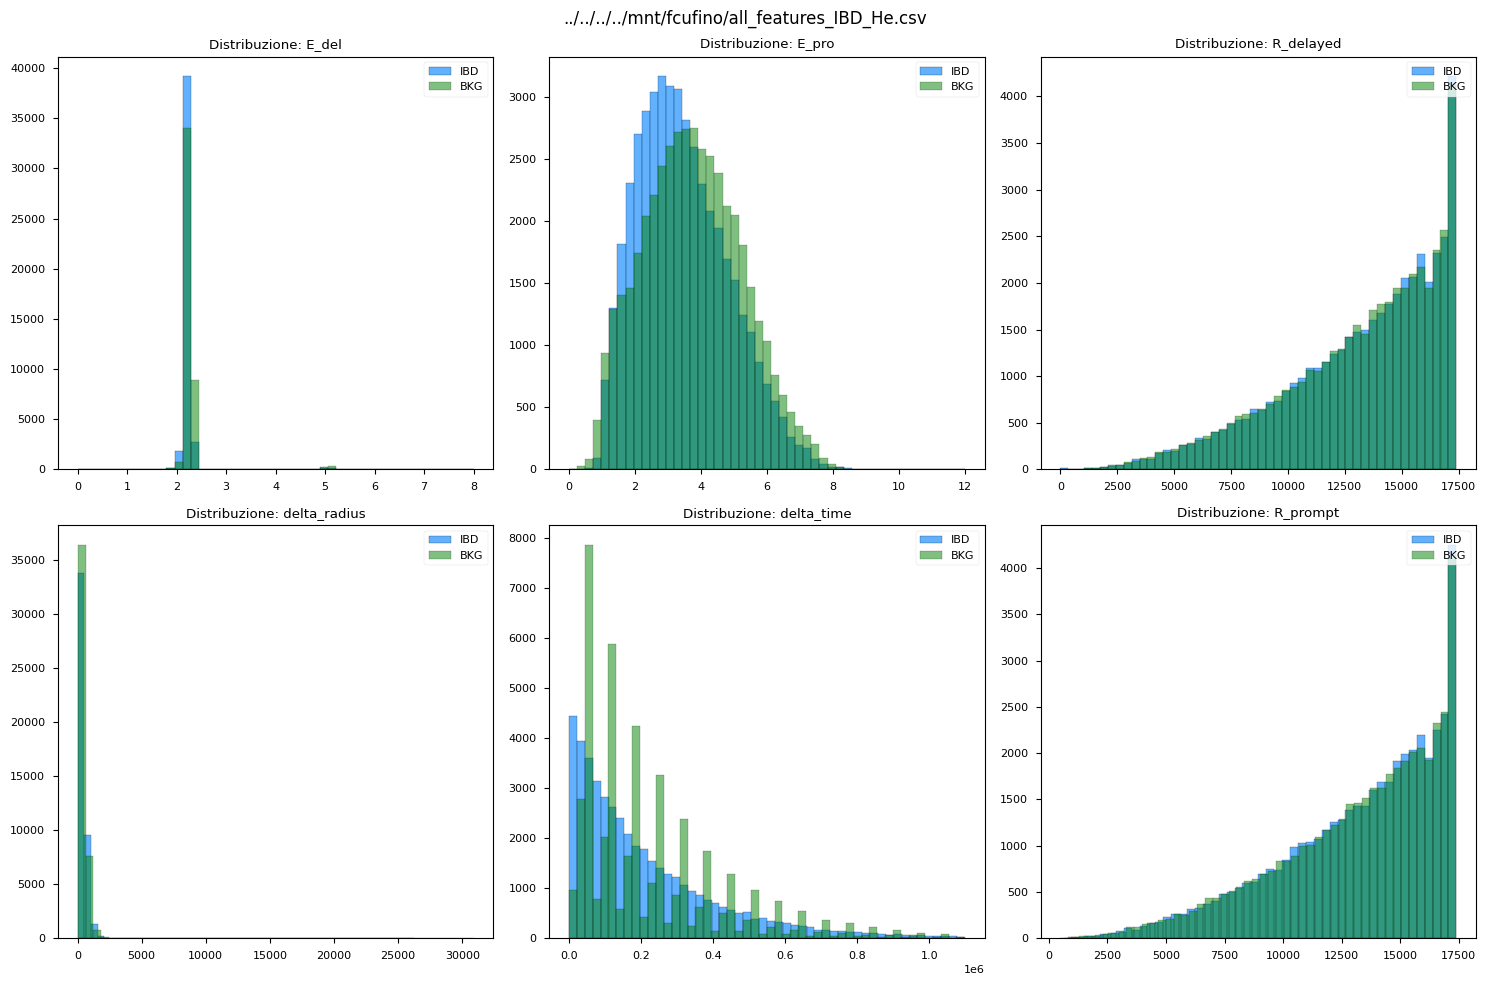

In [483]:
features = ['E_del',"E_pro","R_delayed","delta_radius","delta_time","R_prompt"]
# Definisci le dimensioni della griglia dei subplot
num_rows = 2  # Numero di righe
num_cols = 3  # Numero di colonne

# Crea una figura e una griglia di subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Itera attraverso tutte le features
for idx, feature in enumerate(features):
    # Calcola gli indici della riga e della colonna corrente
    row = idx // num_cols
    col = idx % num_cols

    # Seleziona l'asse corrispondente alla riga e alla colonna corrente
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    if feature == "E_del":
        ax.hist(all_feature[feature][all_feature['Label'] == 1],np.linspace(0,8,50), color='dodgerblue',alpha = 0.7, label='IBD')
        ax.hist(all_feature[feature][all_feature['Label'] == 0],np.linspace(0,8,50), color='green',alpha = 0.5, label='BKG')
    
    elif feature == "E_pro":
        ax.hist(all_feature[feature][all_feature['Label'] == 1],np.linspace(0,12,50), color='dodgerblue',alpha = 0.7, label='IBD')
        ax.hist(all_feature[feature][all_feature['Label'] == 0],np.linspace(0,12,50), color='green',alpha = 0.5, label='BKG')
    else:
        ax.hist(all_feature[feature][all_feature['Label'] == 1],bins=50, color='dodgerblue',alpha = 0.7, label='IBD')
        ax.hist(all_feature[feature][all_feature['Source'] == 0],bins=50, color='green',alpha = 0.5, label='BKG')
    

 
    ax.set_title(f'Distribuzione: {feature}')
    ax.legend(loc='upper right')
    
fig.suptitle(str(file_features))
plt.tight_layout()
plt.show()

# ML Classification Algorithms

Tolgo delta time perchè ha il problema del timestamp e credo che 

In [484]:
from sklearn.model_selection import train_test_split


columns_to_exclude = ['Label', 'Source', 'delta_time']


X = all_feature.drop(columns_to_exclude, axis=1)
Y = all_feature['Label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

## XGBClassifier

In [485]:
from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb

In [486]:
from sklearn.metrics import accuracy_score
import os
import xgboost as xgb

scale_pos_weight = (len(all_feature['Label'])-all_feature['Label'].sum())/all_feature['Label'].sum()

# Verifica se il file del modello esiste
if os.path.isfile(model_path):
    # Carica il modello da file
    model = xgb.sklearn.XGBClassifier()
    model.load_model(model_path)
    print("Model loaded")
else:
    # Crea e addestra il modello se il file non esiste
    model = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=200, max_depth=5, learning_rate = 0.05) #, scale_pos_weight = scale_pos_weight)

    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
    print("Finished training")

    # Salva il modello in file
    model.save_model(model_path)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Calcola l'accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)


Model loaded
Accuracy: 65.18%


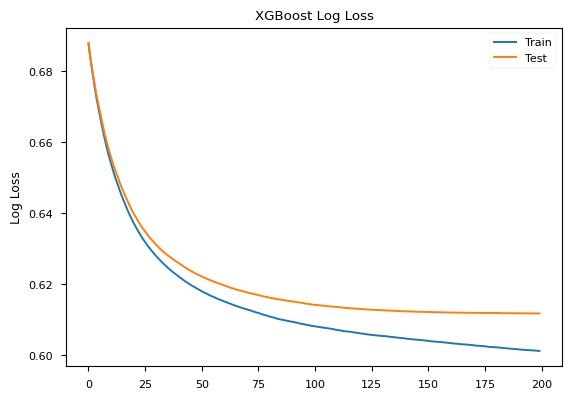

In [487]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')

ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')

plt.show()


In [488]:
import sklearn
print(sklearn.metrics.classification_report(y_test, y_pred))
sklearn.metrics.confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.66      0.62      0.64      8996
         1.0       0.64      0.68      0.66      8971

    accuracy                           0.65     17967
   macro avg       0.65      0.65      0.65     17967
weighted avg       0.65      0.65      0.65     17967



array([[5612, 3384],
       [2873, 6098]])

In [489]:
features_names = [key for key in all_feature.keys() if key!= "Label"]
print(features_names)

['R_prompt', 'E_del', 'delta_radius', 'R_delayed', 'E_pro', 'delta_time', 'Source']


## shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


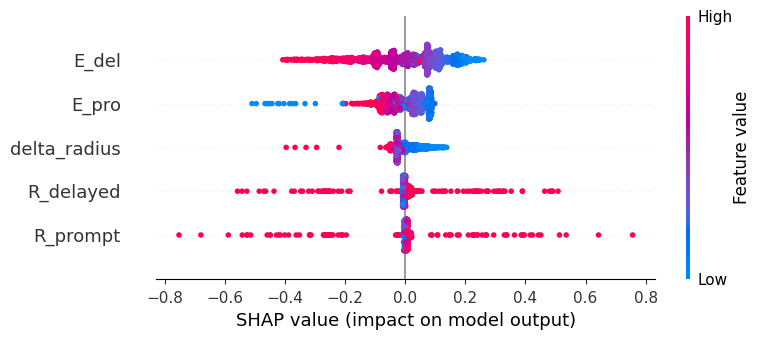

In [490]:
import shap
features_names = X.columns

#Creo un oggetto explainer SHAP
explainer = shap.Explainer(model, X_test[:2000],model_output="probability")

# Calcolo i valori di Shapley per il set di test
shap_values = explainer(X_test[:2000])
 
# Plotto il summary plot di SHAP
shap.summary_plot(shap_values, X_test[:2000], feature_names=features_names);

In [491]:
# shap.plots.bar(shap_values)

## Selezione BDT sul dataset di sola radioattività

In [492]:
all_feature_r = pd.read_csv(file_features)

In [493]:
X_rad_df = all_feature_r[(all_feature_r["Label"] == 0) & (all_feature_r["Source"] == 0)]
X_rad = X_rad_df.drop(['Label', 'Source', 'delta_time'], axis=1)

#Now predict y using model XGBoost thath has been trained
y_rad_pred = model.predict(X_rad)

In [494]:
print(y_rad_pred.sum(), "su", y_rad_pred.shape[0])

TP_bkg = np.logical_and(X_rad_df['Label'] == 0, y_rad_pred == 0)
TN_bkg = np.logical_and(X_rad_df['Label'] == 1, y_rad_pred == 1)
FN_bkg = np.logical_and(X_rad_df["Label"] == 0, y_rad_pred == 1)
FP_bkg = np.logical_and(X_rad_df["Label"] == 1, y_rad_pred == 0) 

print("Efficiency: ", (TP_bkg.sum()/(TP_bkg.sum()+FN_bkg.sum())) * 100)
print("Purity: ", (TP_bkg.sum()/(TP_bkg.sum()+FP_bkg.sum())) * 100)	

16667 su 44916
Efficiency:  62.89295573960282
Purity:  100.0


## Selezione BDT sul dataset di soli veri IBD


In [495]:
X_true_IBD_df = all_feature_r[(all_feature_r["Label"] == 1) & (all_feature_r["Source"] == 1)]
X_true_IBD = X_true_IBD_df.drop(['Label', 'Source', 'delta_time'], axis=1)

#Now predict y using model XGBoost thath has been trained
y_true_IBD_pred = model.predict(X_true_IBD)


In [496]:
print("Venongono selezionati come IBD ", y_true_IBD_pred.sum(),"Su un tot di", y_true_IBD_pred.shape[0])


TP = np.logical_and(X_true_IBD_df['Label'] == 1, y_true_IBD_pred == 1)
TN = np.logical_and(X_true_IBD_df['Label'] == 0, y_true_IBD_pred == 0)
FN = np.logical_and(X_true_IBD_df["Label"] == 1, y_true_IBD_pred == 0)
FP = np.logical_and(X_true_IBD_df["Label"] == 0, y_true_IBD_pred == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

Venongono selezionati come IBD  33607 Su un tot di 49277
Efficiency:  68.20017452361142
Purity:  100.0


# Finale

In [497]:
print("Tabella di features utilizzata: ", file_features)
print("Accuracy BDT: %.2f%%" % (accuracy * 100.0))
print("Efficency testata su veri IBD: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
print("Purity testata su veri IBD: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)

print("Efficency testata su BKG: ", (TP_bkg.sum()/(TP_bkg.sum()+FN_bkg.sum())) * 100)
print("Purity testata su BKG: ", (TP_bkg.sum()/(TP_bkg.sum()+FP_bkg.sum())) * 100)	


Tabella di features utilizzata:  ../../../../mnt/fcufino/all_features_IBD_He.csv
Accuracy BDT: 65.18%
Efficency testata su veri IBD:  68.20017452361142
Purity testata su veri IBD:  100.0
Efficency testata su BKG:  62.89295573960282
Purity testata su BKG:  100.0
